In [1]:
import os
import sys
import ast
import time
sys.path.append('.')
sys.path.append('../')
import numpy as np
import pandas as pd
import json


import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from src.utils.io import (get_matched_data_path,
                          get_matched_metadata_path,
                          get_matched_summary_path,
                          get_metadata_path,
                          get_video_labels_path,
                          get_audio_labels_path,
                          get_figures_dir,
                          get_project_root,
                          get_results_dir,
                          )
from src.methods.prediction_model import (SimpleNN)
from src.utils.train import (train_run)
from src.utils.plots import (multi_label_predictions)
                            
from src.utils.data_prep import (combined_annotations,
                                create_matched_data,
                                create_max_windows,
                                create_summary_data,
                                create_data_splits,
                                setup_dataloaders,
                                give_balanced_weights,
                                adjust_behavior_and_durations)

from config.settings import (SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_W_TROTTING,
                             SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING,
                            SUMMARY_BEHAVIORS_W_TROTTING,
                            SUMMARY_BEHAVIORS_WO_TROTTING,
                             SAMPLING_RATE,
                             id_mapping,)

from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


In [2]:
# Graphing Parameters
import matplotlib as mpl

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 22
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = False

In [3]:
# load matched acceleration and label pairs data, metadata, and summary

all_annotations = combined_annotations(video_path=get_video_labels_path(), 
                                        audio_path=get_audio_labels_path(),
                                        id_mapping=id_mapping) # load annotations 

all_annotations.columns

Index(['id', 'Behavior', 'Timestamp_start', 'Timestamp_end', 'Source'], dtype='object')

In [4]:
all_annotations.Timestamp_start = pd.to_datetime(all_annotations.Timestamp_start)
all_annotations.Timestamp_end = pd.to_datetime(all_annotations.Timestamp_end)
all_annotations['duration'] = (all_annotations.Timestamp_end - all_annotations.Timestamp_start).dt.total_seconds()

In [6]:
print(all_annotations["duration"].describe())
value = 10
quantile = np.mean(all_annotations["duration"] <= value)
print(f"Value {value}s is approximately at the {quantile*100:.2f}th percentile.")

count    12390.000000
mean        37.909282
std        113.595392
min          0.000000
25%          3.000000
50%          8.000000
75%         25.000000
max       2834.000000
Name: duration, dtype: float64
Value 10s is approximately at the 54.26th percentile.


80.57% of the behavior annotations are shorter than 30 seconds in duration. In fact, the median duration is just 8 seconds.

In [7]:
metadata = pd.read_csv(get_metadata_path())

In [10]:
min_durations_list = [20]

for min_duration in min_durations_list:

    dir = os.path.join(get_project_root(), 'data', f"duration{min_duration}")
    os.makedirs(dir, exist_ok=True)


    summary_path = os.path.join(dir, "matched_acc_summary.csv")
    data_path = os.path.join(dir, "matched_acc_data.csv")
    metadata_path = os.path.join(dir, "matched_acc_metadata.csv")

    if not (os.path.exists(summary_path) and os.path.exists(data_path) and os.path.exists(metadata_path)):
        acc_summary, acc_data, acc_data_metadata = create_matched_data(
            metadata, all_annotations, min_duration=min_duration, verbose=True
        )
        acc_summary.to_csv(summary_path, index=False)
        acc_data.to_csv(data_path, index=False)
        acc_data_metadata.to_csv(metadata_path, index=False)
    else:
        acc_summary = pd.read_csv(summary_path)
        acc_data = pd.read_csv(data_path)
        acc_data_metadata = pd.read_csv(metadata_path)

        acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
        acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
        acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING, SUMMARY_BEHAVIORS_WO_TROTTING)
acc_data_metadata = acc_data_metadata.loc[acc_data.index]

acc_data.reset_index()
acc_data_metadata.reset_index()

,index,Unnamed: 0,file path,individual ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,0,46,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.374260
1,1,46,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.374260
2,2,46,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.374260
3,3,46,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.374260
4,4,46,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,jessie,2022,2022-08-12,am,2022-08-12_am,22.374260
...,...,...,...,...,...,...,...,...,...
8580,10440,3341,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,fossey,2022,2022-07-18,pm,2022-07-18_pm,21.301797
8581,10441,3341,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,fossey,2022,2022-07-18,pm,2022-07-18_pm,21.301797
8582,10442,3341,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,fossey,2022,2022-07-18,pm,2022-07-18_pm,21.301797
8583,10443,3341,/mnt/ssd/medhaaga/wildlife/Vectronics/2022_449...,fossey,2022,2022-07-18,pm,2022-07-18_pm,21.301797


In [11]:
acc_data_split = create_max_windows(acc_data=acc_data, window_duration=30.0, sampling_rate=SAMPLING_RATE)
acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]
split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)
print(f"Total {np.sum(np.isnan(acc_data_split.acc_x_ptp_max.values))} annotations have duration less than 2 seconds")

Total 0 annotations have duration less than 2 seconds


In [12]:
split_acc_data.groupby('behavior')['behavior'].count()/len(split_acc_data)

behavior
Feeding       0.024219
Moving        0.146800
Running       0.019821
Stationary    0.809160
Name: behavior, dtype: float64

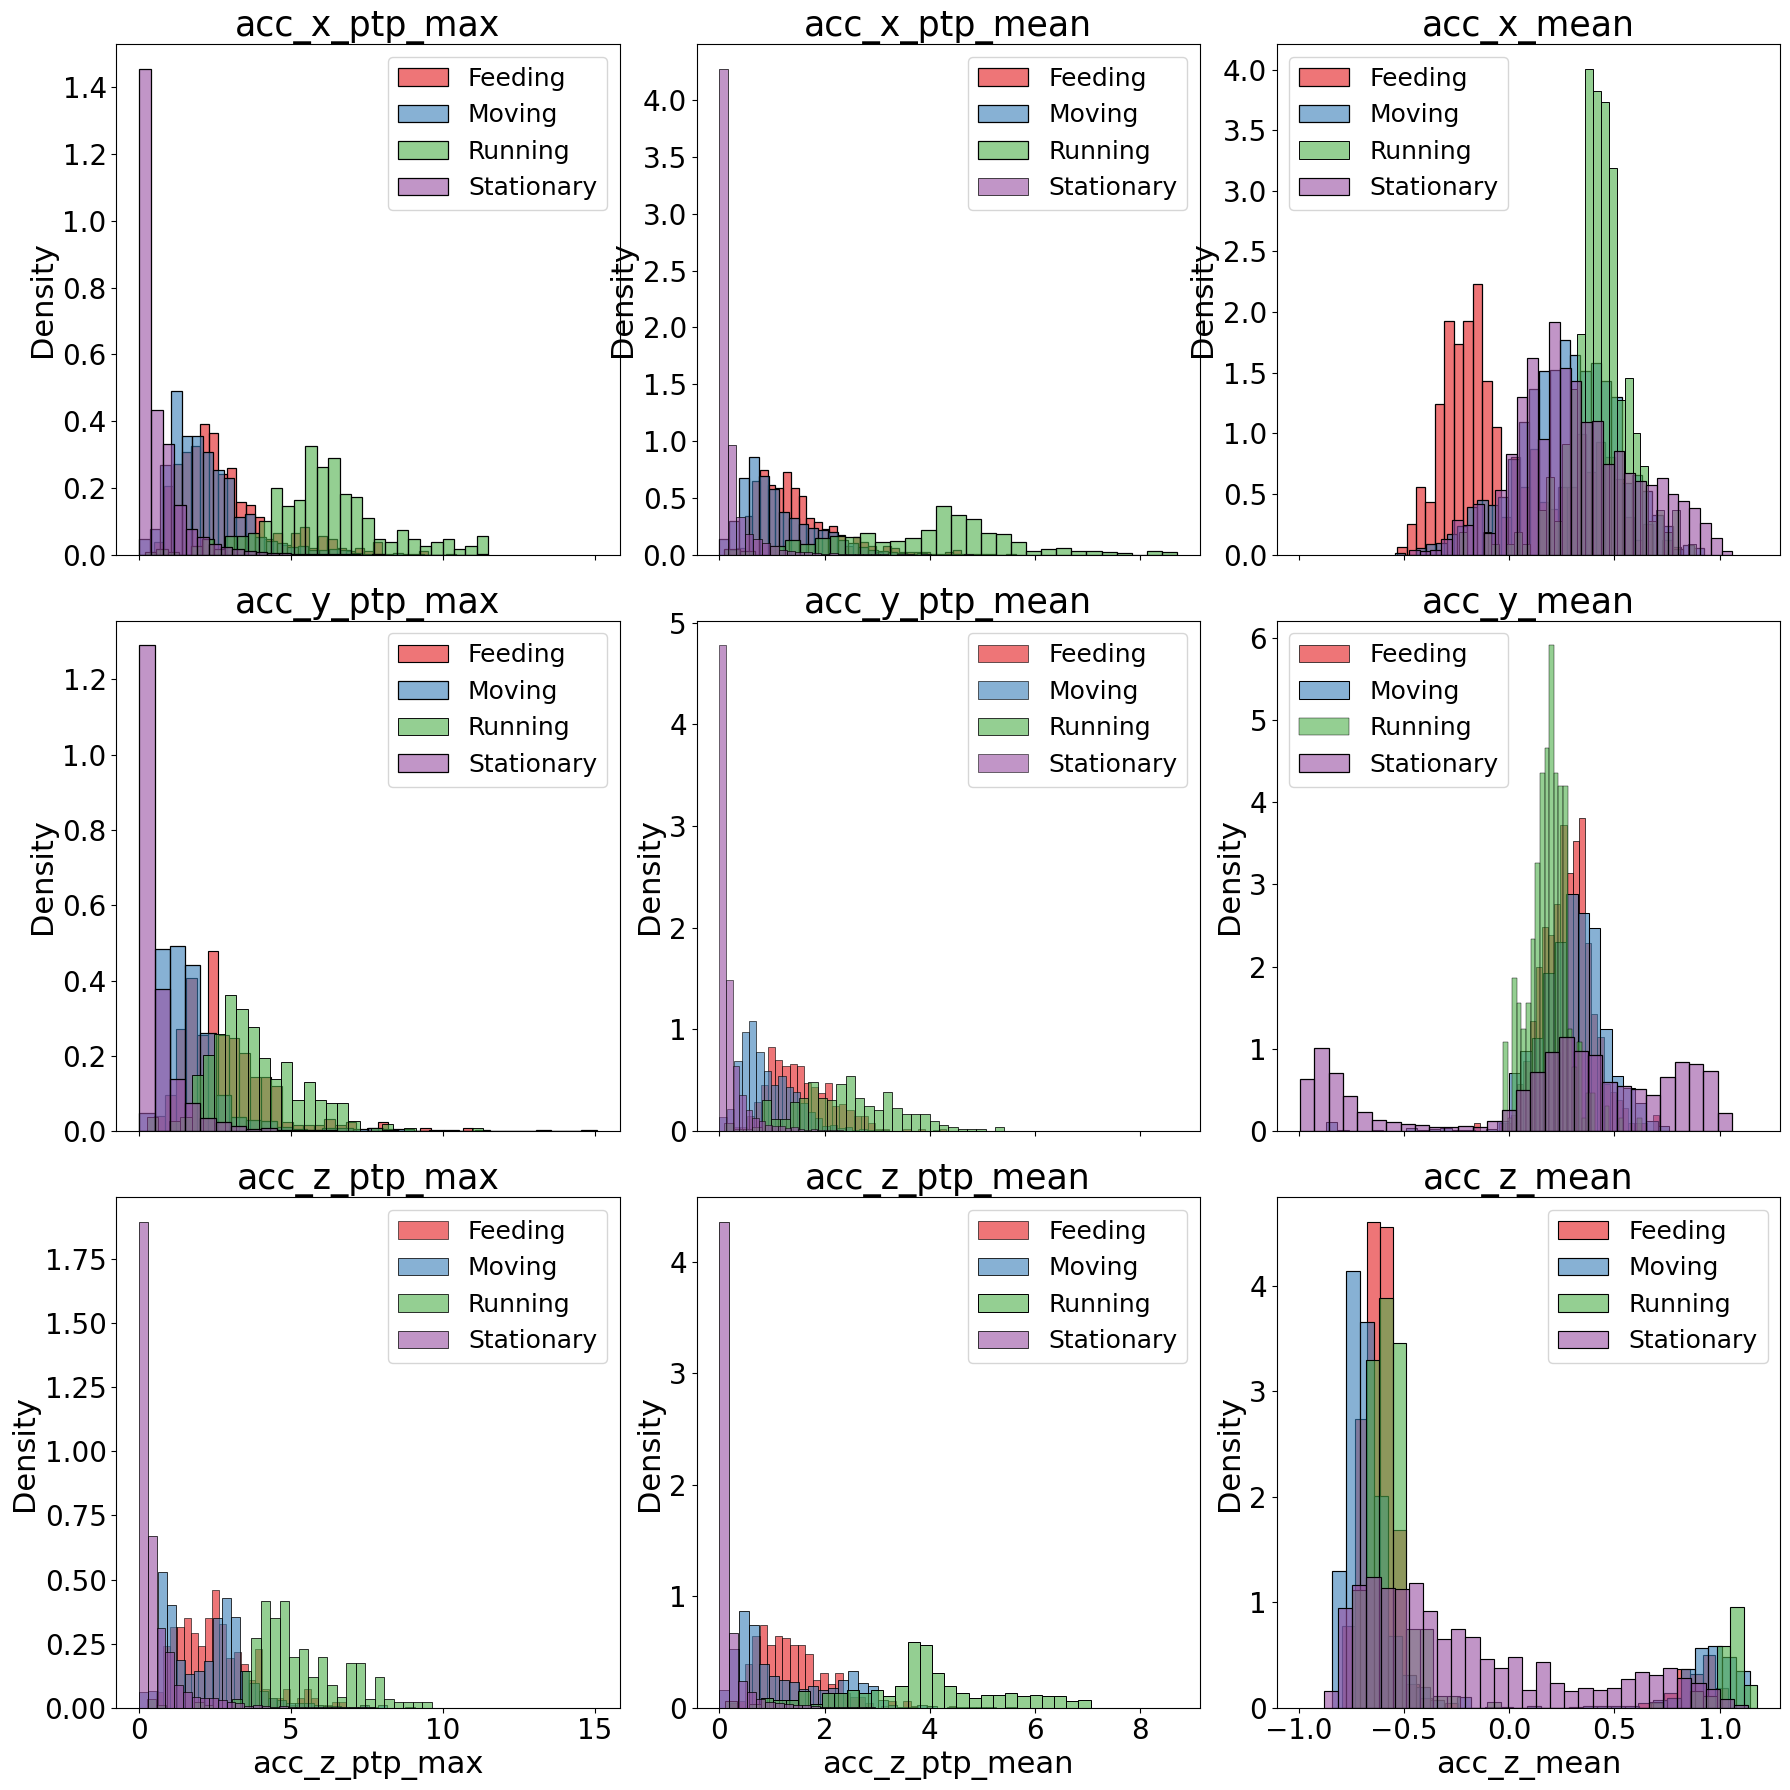

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18), sharey=False, sharex='col')
palette = sns.color_palette("Set1", n_colors=len(SUMMARY_BEHAVIORS_WO_TROTTING))

behaviors_to_plot = acc_data_split['behavior'].unique()
acc_axes = ['acc_x', 'acc_y', 'acc_z']
features = ['ptp_max', 'ptp_mean', 'mean']

for i, axis in enumerate(acc_axes):
    for j, feature in enumerate(features):

        feature = axis + '_' + feature
        ax = axes[i, j]

        for k, behavior in enumerate(SUMMARY_BEHAVIORS_WO_TROTTING):
            sns.histplot(
                acc_data_split[acc_data_split['behavior'] == behavior][feature],
                label=behavior,
                kde=False,
                ax=ax,
                stat='density',
                bins=30,
                color=palette[k],
                alpha=0.6
            )

        ax.set_title(feature)

        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()


In [17]:
from dataclasses import dataclass, field
from typing import  List

@dataclass
class TrainArgs:
    batch_size: int = 32
    num_epochs: int = 100
    theta: float = 0.5
    learning_rate: float = 0.001
    weight_decay: float = 0.0001
    print_freq: int = 10
    verbose: bool = False

@dataclass
class ModelArgs:
    hidden_layers: List[int] = field(default_factory=lambda: [64])
    dropout_rate: float = 0.5

@dataclass
class DataArgs:
    min_duration: float = 30.0

train_args = TrainArgs()
model_args = ModelArgs()
data_args = DataArgs()

In [21]:
training_results_dir = os.path.join(get_results_dir(), 'training_results')
os.makedirs(training_results_dir, exist_ok=True)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
feature_cols = [
    'acc_x_ptp_max', 'acc_x_ptp_mean', 'acc_x_mean',
    'acc_y_ptp_max', 'acc_y_ptp_mean','acc_y_mean',
    'acc_z_ptp_max', 'acc_z_ptp_mean', 'acc_z_mean',
]

In [ ]:
min_durations_list = [20]
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for min_duration in min_durations_list:

    data_args.min_duration = min_duration
    # read acceleration data
    data_path = os.path.join(get_project_root(), 'data', 'duration'+str(data_args.min_duration), "matched_acc_data.csv")
    acc_data = pd.read_csv(data_path)
    acc_data['acc_x'] = acc_data['acc_x'].apply(json.loads)
    acc_data['acc_y'] = acc_data['acc_y'].apply(json.loads)
    acc_data['acc_z'] = acc_data['acc_z'].apply(json.loads)

    acc_data = adjust_behavior_and_durations(acc_data, SUMMARY_COLLAPSE_BEHAVIORS_MAPPING_WO_TROTTING, SUMMARY_BEHAVIORS_WO_TROTTING)
    acc_data_metadata = acc_data_metadata.loc[acc_data.index]

    acc_data.reset_index()
    acc_data_metadata.reset_index()
    
    # split it in min_duration chunks
    acc_data_split = create_max_windows(acc_data=acc_data, window_duration=data_args.min_duration, sampling_rate=SAMPLING_RATE)
    acc_data_split = acc_data_split[acc_data_split.duration >= 4.0]

    # create summary statistics data
    split_acc_data = create_summary_data(acc_data_split, sampling_rate=SAMPLING_RATE)

    # create train, val, and test splits
    X_train, y_train, X_val, y_val, X_test, y_test = create_data_splits(acc_data_split, feature_cols=feature_cols)

    for theta in theta_list:

        train_args.theta = theta

        # setup dataloaders
        train_dataloader, val_dataloader, test_dataloader = setup_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, train_args)

        # setup model, loss, and optimizer
        model = SimpleNN(input_dim=X_train.shape[1], n_ouputs=len(SUMMARY_BEHAVIORS_WO_TROTTING), hidden_layers=model_args.hidden_layers, dropout_rate=model_args.dropout_rate).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=train_args.learning_rate, weight_decay=train_args.weight_decay)

        #### Training
        train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, train_args, device)
        model = train_obj['model'].to(device)
        training_stats = train_obj['training_stats']

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{train_args.theta}")
        os.makedirs(model_dir, exist_ok=True)

        torch.save(model, os.path.join(model_dir, 'model.pt'))
        json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
        with open(json_training_stats_file, 'w') as f:
            json.dump(training_stats, f)

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
        np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])
        np.save(os.path.join(model_dir, 'val_scores.npy'),  train_obj['val_scores'])

        # save true and predicted validation classes along with val metadata
        np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
        np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])
        np.save(os.path.join(model_dir, 'test_scores.npy'),  train_obj['test_scores'])
    

In [24]:
label_encoder = LabelEncoder()
label_encoder.fit(SUMMARY_BEHAVIORS_WO_TROTTING)

LabelEncoder()

/tmp/ipykernel_153838/998706376.py:27: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


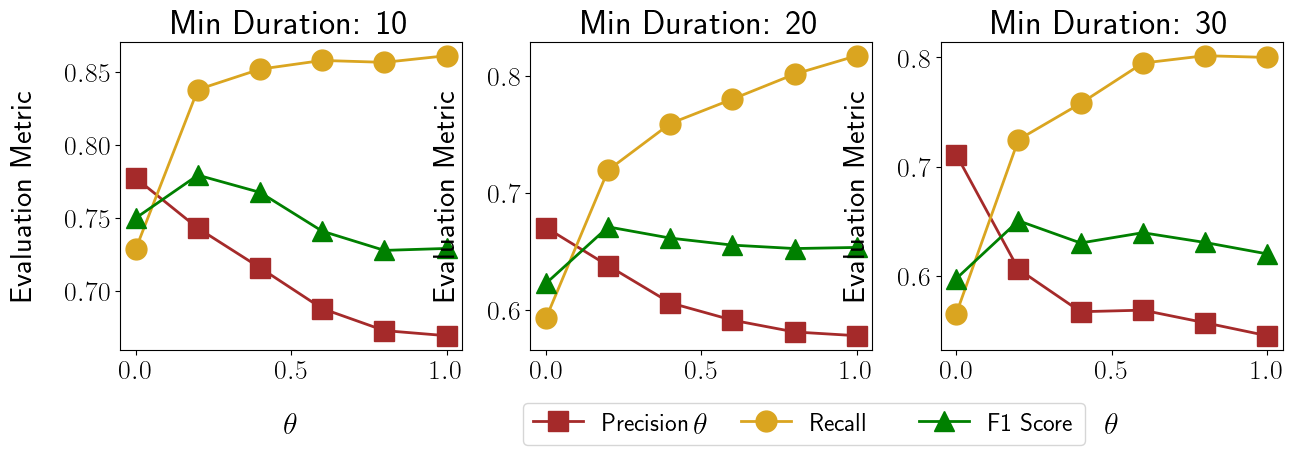

In [69]:
fig, axs = plt.subplots(1, len(min_durations_list), figsize=(5*len(min_durations_list), 4), sharey=True)
colors = ['brown', 'goldenrod', 'green']
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

min_durations_list = [10, 20, 30]

for i, min_duration in enumerate(min_durations_list):
    
    precisions, recalls, f1scores = np.zeros(len(theta_list)), np.zeros(len(theta_list)), np.zeros(len(theta_list))

    for j, theta in enumerate(theta_list):

        model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")

        precisions[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
        recalls[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
        f1scores[j] = multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    axs[i].plot(theta_list, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
    axs[i].plot(theta_list, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
    axs[i].plot(theta_list, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
    axs[i].set_title(f"Min Duration: {min_duration}")
    axs[i].set_xlabel(r'$\theta$', labelpad=20)
    axs[i].set_ylabel('Evaluation Metric', labelpad=20)

axs[0].legend(loc='lower center', ncol=3, bbox_to_anchor=(2.0,-0.35))
plt.tight_layout()
plt.show()  

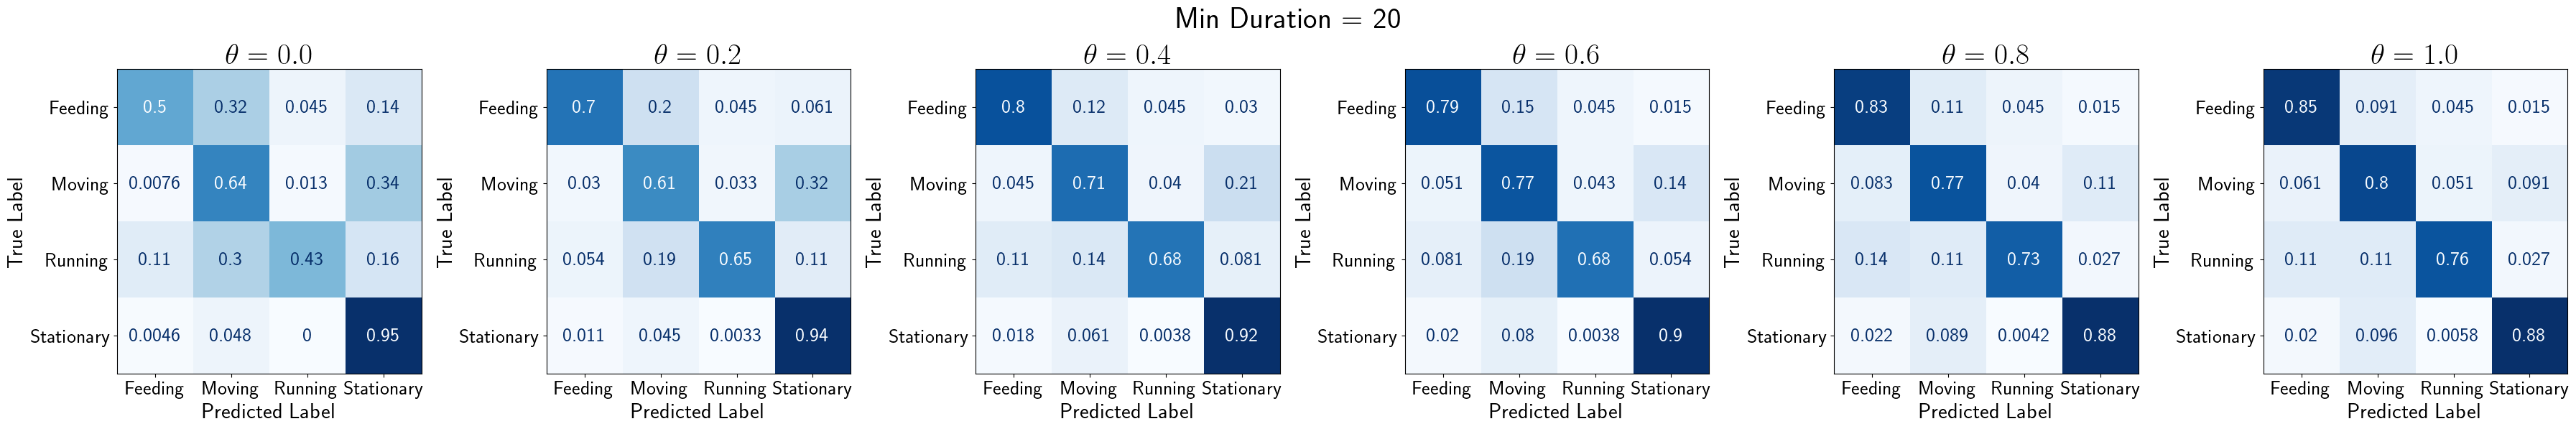

In [58]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)
theta_list = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
min_duration = 20

fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()

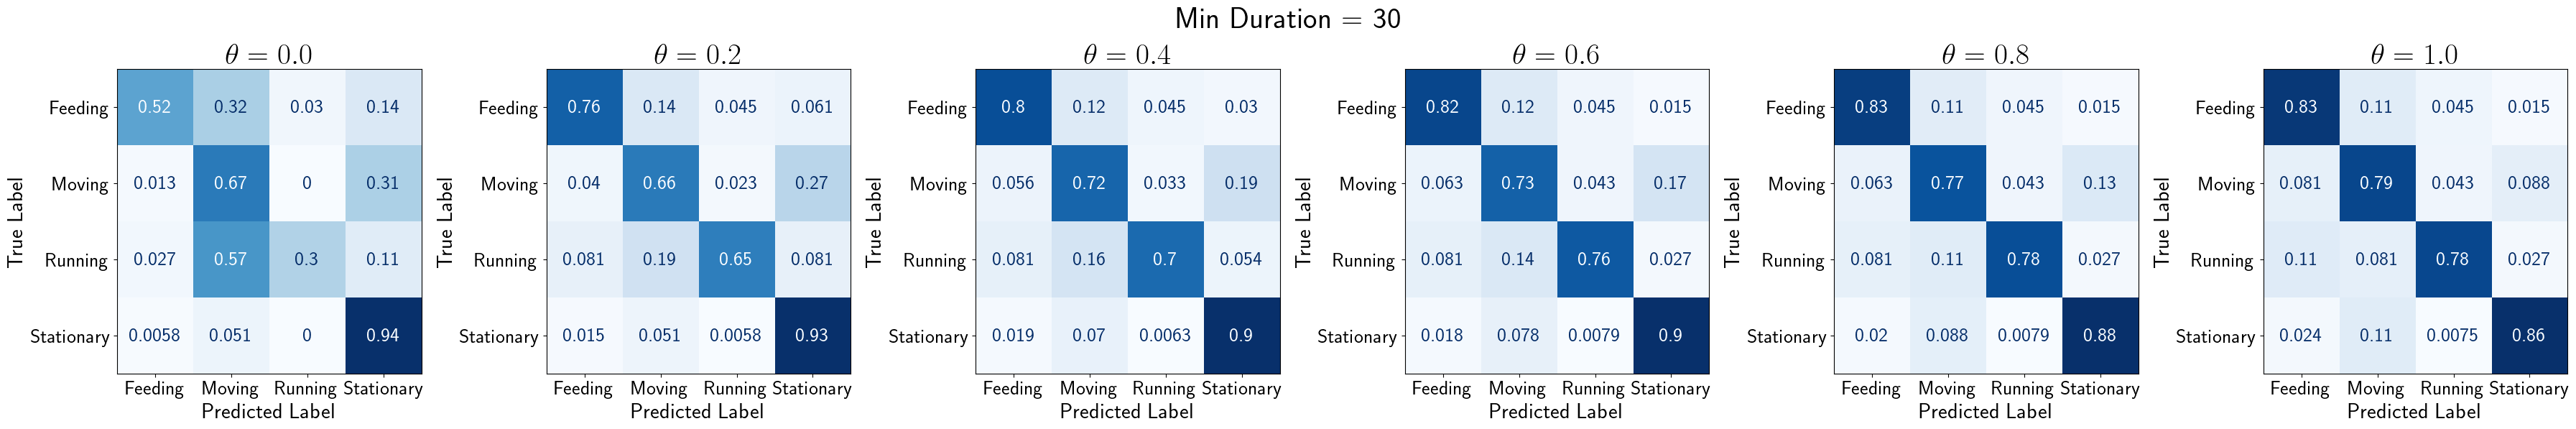

In [59]:
fig, axs = plt.subplots(1, len(theta_list), figsize=(6*len(theta_list), 6))
min_duration = 30

for i, theta in enumerate(theta_list):

    model_dir = os.path.join(training_results_dir, f"duration{min_duration}_theta{theta}")
    val_true = np.load(os.path.join(model_dir, 'test_true_classes.npy'))
    val_predictions = np.load(os.path.join(model_dir, 'test_predictions.npy'))

    cm = confusion_matrix(val_true, val_predictions, normalize='true')

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=label_encoder.classes_, 
    )
    disp.plot(ax=axs[i], cmap='Blues', colorbar=False)

    # Optional: format text size
    for text in disp.text_.ravel():
        text.set_fontsize(20)

    axs[i].set_title(f"$\\theta = {theta}$", fontsize=30)
    axs[i].set_xlabel("Predicted Label")
    axs[i].set_ylabel("True Label")

fig.suptitle(f"Min Duration = {min_duration}", fontsize=30)
plt.tight_layout()
plt.show()